# PancakeSwap momentum trading, version 2

This strategy backtesting example builds on [more naive version 1](https://tradingstrategy.ai/docs/programming/algorithms/pancakeswap-momentum-naive.html).

The improvements this version has:

* We have added liquidity checks - do not invest in trading pairs with low or no liquidity
* We backtest on two exchanges on the opposite of one: PancakeSwap and PancakeSwap v2
* We have added 1/N weighting system to reduce risk, as before momentum = direct alpha signal
* We filter out duplicate base tokens, as on n DEX markets the same token may trade on multiple pairs

This example is still unrealistic:

* Price impact it still not considered, as if the profits grow too much, then the algo will buy too small cap tokens without understanding the underlying price

## Strategy and backtesting parameters

Here we define all parameters that affect the backtest outcome.

In [71]:
import seaborn
import pandas as pd
from tradingstrategy.timebucket import TimeBucket

# The starting date of the backtest
# Note: PancakeSwap v2 deployed Apr 2021
start = pd.Timestamp('2020-11-01 00:00')

# The ending date of the backtest
end = pd.Timestamp('2021-12-30 00:00')
#end = pd.Timestamp('2020-12-01 00:00')

# Start backtesting with $10k in hand
initial_cash = 10_000

# Prefiltering to limit the pair set to speed up computations
# How many USD all time buy volume the pair must have had
# to be included in the backtesting
prefilter_min_buy_volume = 5_000_000

# The liquidity threshold for a token to be considered
# risk free enough to be purchased
min_liquidity_threshold = 750_000

# How many tokens we can hold in our portfolio
# If there are more new tokens coming to market per day,
# we just ignore those with less liquidity
max_assets_per_portfolio = 4

# How many % of all value we hold in cash all the time,
# so that we can sustain hits
cash_buffer = 0.50

# Use daily candles to run the algorithm
candle_time_frame = TimeBucket.d1

# Print algorithm internal state while it is running to debug issues
debug = False

## Creating trading universe

First let's import libraries and initialise our dataset client.

In [72]:
try:
    import tradingstrategy
except ImportError:
    !pip install tradingstrategy
    import site
    site.main()

from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


In [73]:
# If you need to enable loger for QTrader debugging
import sys
import logging

logger = logging.getLogger("Notebook")
logging.basicConfig(stream=sys.stdout, level=logging.WARNING)
logging.info("Logging has been set up")

logger = logging.getLogger(__name__)

Let's create a pair universe for PancakeSwap.
We will create a dataset of 2d candles that trade on PancakeSwap on Binance Smart Chain.

In [74]:
import pandas as pd
from tradingstrategy.chain import ChainId
from tradingstrategy.pair import PandasPairUniverse

columnar_pair_table = client.fetch_pair_universe()

exchange_universe = client.fetch_exchange_universe()

all_pairs_dataframe = columnar_pair_table.to_pandas()


our_exchanges = [
    exchange_universe.get_by_chain_and_slug(ChainId.bsc, "pancakeswap"),
    exchange_universe.get_by_chain_and_slug(ChainId.bsc, "pancakeswap-v2"),
]

our_exchange_ids = [e.exchange_id for e in our_exchanges]

our_pairs: pd.DataFrame = all_pairs_dataframe.loc[
    (all_pairs_dataframe['exchange_id'].isin(our_exchange_ids)) &  # Trades on Sushi
    (all_pairs_dataframe['buy_volume_all_time'] > prefilter_min_buy_volume)  # 500k min buys
]

# Create a Python set of pair ids
wanted_pair_ids = our_pairs["pair_id"]

# Make the trading pair data easily accessible
pair_universe = PandasPairUniverse(our_pairs)
pair_universe.build_index()

print(f"Our trading universe has {len(pair_universe.get_all_pair_ids())} pairs that meet the prefiltering criteria")

Our trading universe has 2011 pairs that meet the prefiltering criteria


## Construct backtesting universe

Get daily candles and filter them against our wanted pair set.

We take all trading pairs registered on  (as the writing of this all Uniswap v2 compatible exchanges).
As the number of trading pairs is very high (50k+).
Most of these trading pairs are random noise and crap.
We reduce the number of trading pairs to speed up the backtest simulation, but this also introduce some
survivorship bias.

In [75]:
from tradingstrategy.frameworks.qstrader import prepare_candles_for_qstrader
from tradingstrategy.liquidity import GroupedLiquidityUniverse
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.candle import GroupedCandleUniverse
from tradingstrategy.exchange import ExchangeUniverse, Exchange

# Decompress the pair dataset to Python map
columnar_pair_table = client.fetch_pair_universe()

# Get daily candles as Pandas DataFrame
all_candles = client.fetch_all_candles(candle_time_frame).to_pandas()
filtered_candles = all_candles.loc[all_candles["pair_id"].isin(wanted_pair_ids)]
candle_universe = GroupedCandleUniverse(prepare_candles_for_qstrader(filtered_candles), timestamp_column="Date")

all_liquidity = client.fetch_all_liquidity_samples(TimeBucket.d1).to_pandas()
filtered_liquidity = all_liquidity.loc[all_liquidity["pair_id"].isin(wanted_pair_ids)]
filtered_liquidity = filtered_liquidity.set_index(filtered_liquidity["timestamp"])
liquidity_universe = GroupedLiquidityUniverse(filtered_liquidity)

data_start, data_end = candle_universe.get_timestamp_range()

print(f"""
Datafeeds set up.

Time periods
- Backtesting: {start} - {end}
- Candle data: {data_start} - {data_end}

Our trading universe for {candle_time_frame.value} candles is
- {len(our_exchanges)} exchanges
- {len(wanted_pair_ids)} pairs
- {len(filtered_candles)} candles
- {len(filtered_liquidity)} liquidity samples

The source data for {candle_time_frame.value} has
- {len(columnar_pair_table)} pairs
- {len(all_candles)} candles
""")

# Check that our backtesting time range and timestamp iterator matches
# with the data we have
assert len(candle_universe.get_all_samples_by_timestamp(start)) > 0, f"No candles at start: {start}"
assert len(candle_universe.get_all_samples_by_timestamp(end)) > 0, f"No candles at end: {end}"


Datafeeds set up.

Time periods
- Backtesting: 2020-11-01 00:00:00 - 2021-12-30 00:00:00
- Candle data: 2020-09-19 00:00:00 - 2022-01-20 00:00:00

Our trading universe for 1d candles is
- 2 exchanges
- 2011 pairs
- 374507 candles
- 327079 liquidity samples

The source data for 1d has
- 78275 pairs
- 4396288 candles



## Creating the alpha model

In [76]:
from tradingstrategy.pair import DEXPair
from tradingstrategy.liquidity import LiquidityDataUnavailable
from typing import Dict
from collections import Counter
from collections import defaultdict

from qstrader.alpha_model.alpha_model import AlphaModel


def fix_qstrader_date(ts: pd.Timestamp) -> pd.Timestamp:
    """Quick-fix for Qstrader to use its internal hour system.

    TODO: Fix QSTrader framework in long run
    """
    return ts.replace(hour=0, minute=0)


class MomentumAlphaModel(AlphaModel):
    """An alpha model that ranks pairs by the daily upwords price change %."""

    def __init__(
            self,
            exchange_universe: ExchangeUniverse,
            pair_universe: PandasPairUniverse,
            candle_universe: GroupedCandleUniverse,
            liquidity_universe: GroupedLiquidityUniverse,
            data_handler=None
    ):
        self.exchange_universe = exchange_universe
        self.pair_universe = pair_universe
        self.candle_universe = candle_universe
        self.liquidity_universe = liquidity_universe
        self.data_handler = data_handler
        self.liquidity_reached_state = {}

    def is_funny_price(self, usd_unit_price: float) -> bool:
        """Avoid taking positions in tokens with too funny prices.

        Might cause good old floating point to crap out.
        """
        return (usd_unit_price < 0.0000001) or (usd_unit_price > 100_000)

    def translate_pair(self, pair_id: int) -> str:
        """Make pari ids human readable for logging."""
        pair_info = self.pair_universe.get_pair_by_id(pair_id)
        return pair_info.get_friendly_name(self.exchange_universe)

    def filter_duplicate_base_tokens(self, alpha_signals: Counter, debug_data: dict) -> Counter:
        """Filter duplicate alpha signals for trading pairs sharing the same base token.

        This is because on DEX markets, the base token may trade with several quote tokens.

        For example, we can end up holding BNB by buying
        - WBNB-BUSD
        - WBNB-USDT

        For the portfolio, it does not matter which route we ended up buying the token
        (although this matters for the price impact).

        We use the already resolved pair data to check for the duplicates.
        We'll just filter out the second entry (worse alpha).
        """
        accumulated_quote_tokens = set()
        filtered_alpha = Counter()
        for pair_id, alpha in alpha_signals.most_common():
            pair: DEXPair = debug_data[pair_id]["pair"]
            base_token = pair.base_token_symbol
            if base_token in accumulated_quote_tokens:
                continue
            filtered_alpha[pair_id] = alpha
            accumulated_quote_tokens.add(base_token)
        return filtered_alpha

    def __call__(self, ts: pd.Timestamp, debug_details: Dict) -> Dict[int, float]:
        """
        Produce the dictionary of scalar signals for
        each of the Asset instances within the Universe.

        :param ts: Candle timestamp iterator

        :return: Dict(pair_id, alpha signal)
        """

        ts = fix_qstrader_date(ts)

        # Calculate momentum based on the candles one day before today.
        # For the simulation to the coherent, we need to make trading decisions
        # at the start of the day based on the momentum we have withnessed
        # yesterday.
        ts_yesterday = ts - pd.Timedelta(days=1)

        # For each pair, check the the diff between opening and closingn price
        timepoint_candles = self.candle_universe.get_all_samples_by_timestamp(ts_yesterday)
        alpha_signals = Counter()

        if len(timepoint_candles) == 0:
            print(f"No candles at {ts}")

        ts_: pd.Timestamp
        candle: pd.Series

        extra_debug_data = defaultdict(dict)

        # Iterate over all candles for all pairs in this timestamp (ts)
        for ts_, candle in timepoint_candles.iterrows():
            pair_id = candle["pair_id"]
            open = candle["Open"]  # QStrader data frames are using capitalised version of OHLCV core variables
            close = candle["Close"]  # QStrader data frames are using capitalised version of OHLCV core variables
            pair = pair_universe.get_pair_by_id(pair_id)

            if self.is_funny_price(open) or self.is_funny_price(close):
                # This trading pair is too funny that we do not want to play with it
                continue

            # We define momentum as how many % the trading pair price gained yesterday
            momentum = (close - open) / open
            momentum = max(0, momentum)

            # This pair has positive momentum, check if it has enough available liquidity
            available_liquidity_for_pair = 0
            if momentum > 0:

                # Check for the liquidity requirement
                try:
                    available_liquidity_for_pair = self.liquidity_universe.get_closest_liquidity(pair_id, ts)
                except LiquidityDataUnavailable as e:
                    # There might be holes in the data, because BSC network not syncing properly,
                    # BSC blockchain was halted or because BSC nodes themselves had crashed.
                    # In this case, we just assume the liquidity was zero and don't backtest.
                    # logger.warning(f"No liquidity data for pair {pair}, currently backtesting at {ts}")
                    available_liquidity_for_pair = 0

            if available_liquidity_for_pair >= min_liquidity_threshold:
                alpha_signals[pair_id] = momentum
            else:
                # No alpha for illiquid pairs
                alpha_signals[pair_id] = 0

            extra_debug_data[pair_id] = {
                "pair": pair,
                "open": open,
                "close": close,
                "momentum": momentum,
                "liquidity": available_liquidity_for_pair
            }

        # Pick top 10 momentum asset and filter out DEX duplicates
        filtered_signals = self.filter_duplicate_base_tokens(alpha_signals, extra_debug_data)
        top_signals = filtered_signals.most_common(max_assets_per_portfolio)

        # Use 1/N weighting system to reduce risk,
        # otherwise the algo could go 99% in to some token that had 10,000% paper gain
        weighed_signals = {}
        for idx, tuple in enumerate(top_signals, 1):
            pair_id, alpha = tuple
            weighed_signals[pair_id] = 1 / idx

        # Debug dump status
        if debug:
            for pair_id, momentum in top_signals:
                debug_data = extra_debug_data[pair_id]
                pair = debug_data["pair"]
                print(f"{ts}: Signal for {pair.get_ticker()} (#{pair.pair_id}) is {momentum * 100:,.2f}%, open: {debug_data['open']:,.8f}, close: {debug_data['close']:,.8f}")

        debug_details["signals"]: weighed_signals.copy()

        return dict(weighed_signals)

print("Alpha model created")

Alpha model created


## Setting up the strategy backtest

We have alpha model and trading universe set up, so next we will create a backtest simulation
where we feed all the data we set up for the backtest session.

In [77]:
from qstrader.asset.universe.static import StaticUniverse
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.simulation.event import SimulationEvent
from qstrader.simulation.everyday import EverydaySimulationEngine
from qstrader.trading.backtest import BacktestTradingSession
from tradingstrategy.frameworks.qstrader import TradingStrategyDataSource

data_source = TradingStrategyDataSource(exchange_universe, pair_universe, candle_universe)

strategy_assets = list(data_source.asset_bar_frames.keys())
strategy_universe = StaticUniverse(strategy_assets)

data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])

# Construct an Alpha Model that simply provides a fixed
# signal for the single GLD ETF at 100% allocation
# with a backtest that does not rebalance
strategy_alpha_model = MomentumAlphaModel(
    exchange_universe,
    pair_universe,
    candle_universe,
    liquidity_universe)

strategy_backtest = BacktestTradingSession(
    start,
    end,
    strategy_universe,
    strategy_alpha_model,
    initial_cash=initial_cash,
    rebalance='daily',
    long_only=True,  # Spot markets do not support shorting
    cash_buffer_percentage=cash_buffer,
    data_handler=data_handler,
    simulation_engine=EverydaySimulationEngine(start, end)
)

print("Strategy set up complete")


Initialising simulated broker "Backtest Simulated Broker Account"...
(2020-11-01 00:00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2020-11-01 00:00:00) - subscription: 10000.00 subscribed to portfolio "000001"
Strategy set up complete


## Running the strategy backtest

Next we run the strategy. This can take potentially many minutes, as it crunches through some data.

The notebook displays a HTML progress bar is displayed during the run, and the estimation when the simulation
is complete.

In [78]:
from tqdm.autonotebook import tqdm

max_events = len(strategy_backtest.prefetch_simulation_events())

# Run the test with a nice progress bar
with tqdm(total=max_events) as progress_bar:
    def progress_callback(idx: int, dt: pd.Timestamp, evt: SimulationEvent):
        progress_bar.set_description(f"Simulation at day {dt.date()}")
        progress_bar.update(1)

    event_stream = strategy_backtest.run(progress_callback=progress_callback, logging=True)

print("Backtest complete")

  0%|          | 0/1700 [00:00<?, ?it/s]

No candles at 2021-11-22 00:00:00
No candles at 2021-11-23 00:00:00
No candles at 2021-11-24 00:00:00
No candles at 2021-11-25 00:00:00
No candles at 2021-11-26 00:00:00
No candles at 2021-11-29 00:00:00
No candles at 2021-11-30 00:00:00
No candles at 2021-12-01 00:00:00
No candles at 2021-12-02 00:00:00
No candles at 2021-12-03 00:00:00
Backtest complete


## Analyzing the strategy results

After the strategy is run, we will display charts and statistics on its performance.

In [79]:
from tradingstrategy.frameworks.qstrader import analyse_trade_history
from tradingstrategy.frameworks.qstrader import analyse_portfolio_development

# "000001" is the default name given for the default portfolio by QSTrader
portfolio = strategy_backtest.broker.portfolios["000001"]
trade_analysis = analyse_trade_history(portfolio.history)
portfolio_analysis = analyse_portfolio_development(event_stream)

### Summary of trades

This displays number of trades, how many we won and lost.

In [80]:
from IPython.core.display import HTML
from IPython.display import display

from tradingstrategy.analysis.tradeanalyzer import TradeSummary

cash_left = strategy_backtest.broker.get_total_portfolio_cash_balances()
summary: TradeSummary = trade_analysis.calculate_summary_statistics(initial_cash, cash_left)

display(summary.to_dataframe())

,0
Return %,47606744%
Cash at start,"$10,000.00"
Value at end,"$4,760,684,440.18"
Trade win percent,46%
Total trades done,912
Won trades,417
Lost trades,495
Stop losses triggered,0
Stop loss % of all,0%
Stop loss % of lost,0%


### Tearsheet chart

Tearsheet displays the portfolio profit and risk over the time.

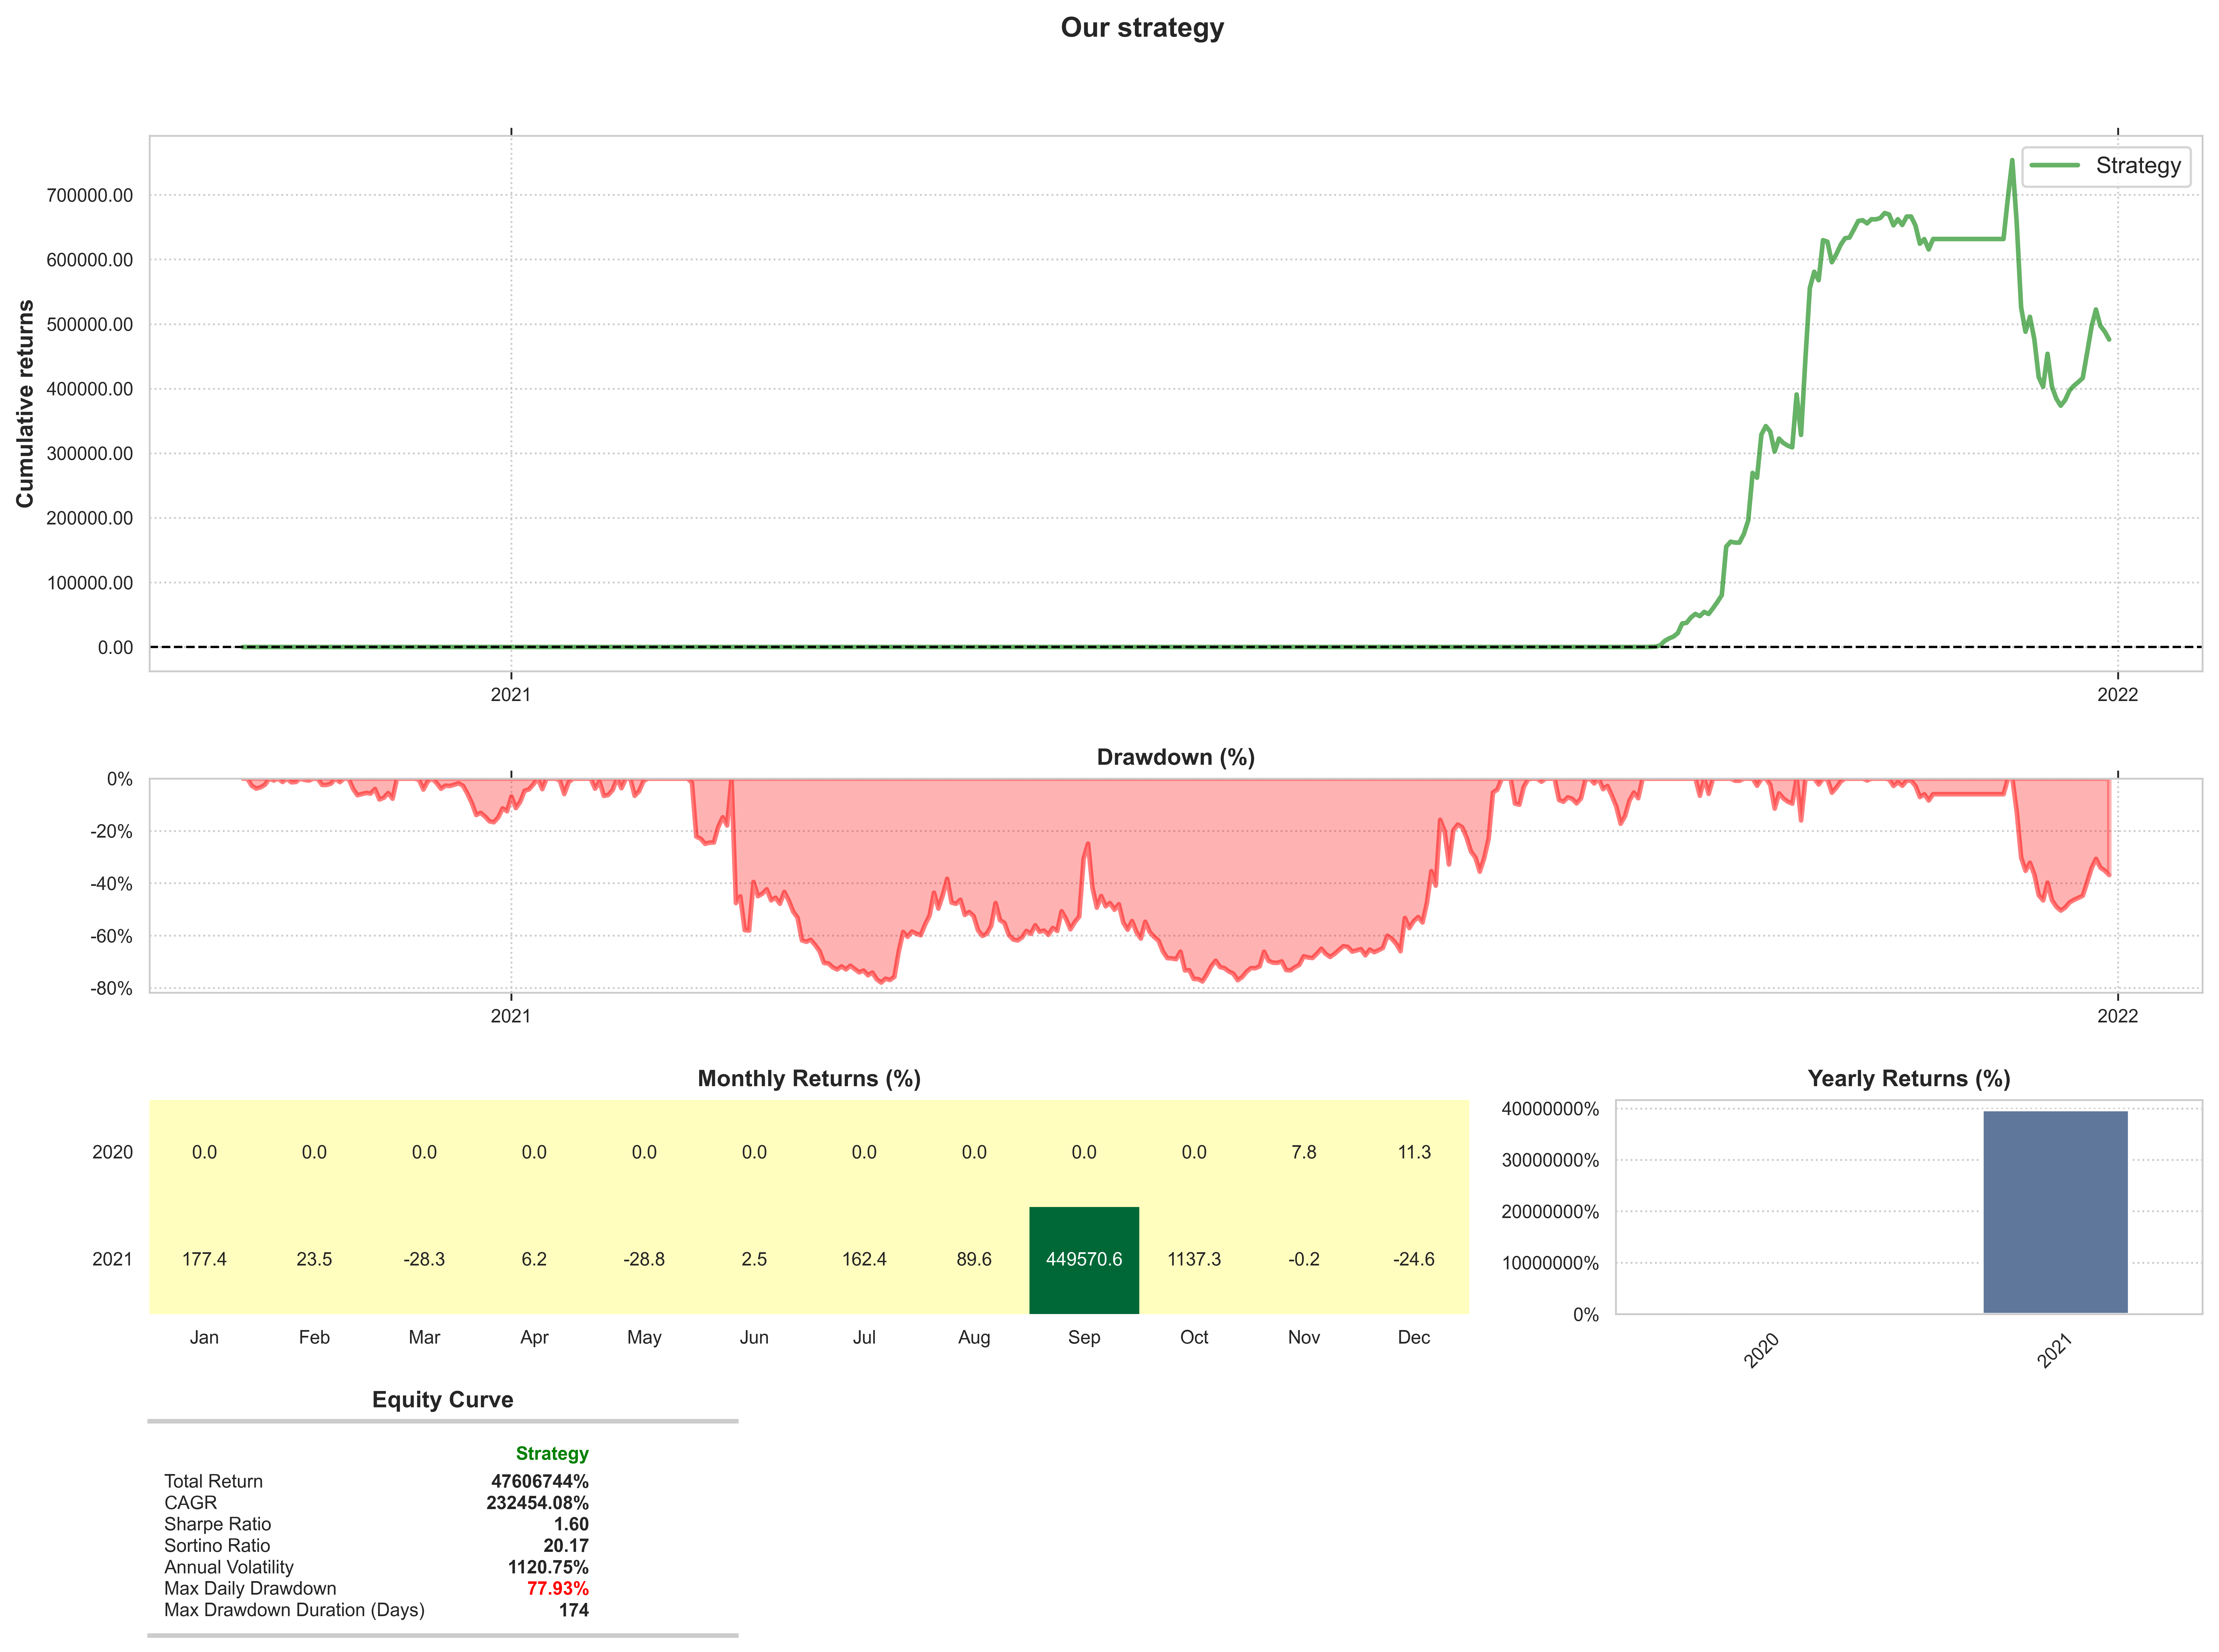

In [81]:
from qstrader.statistics.tearsheet import TearsheetStatistics

tearsheet = TearsheetStatistics(
    strategy_equity=strategy_backtest.get_equity_curve(),
    title=f'Our strategy'
)

tearsheet.plot_results()

### Trade success histogram

Show the distribution of won and lost trades as a histogram.

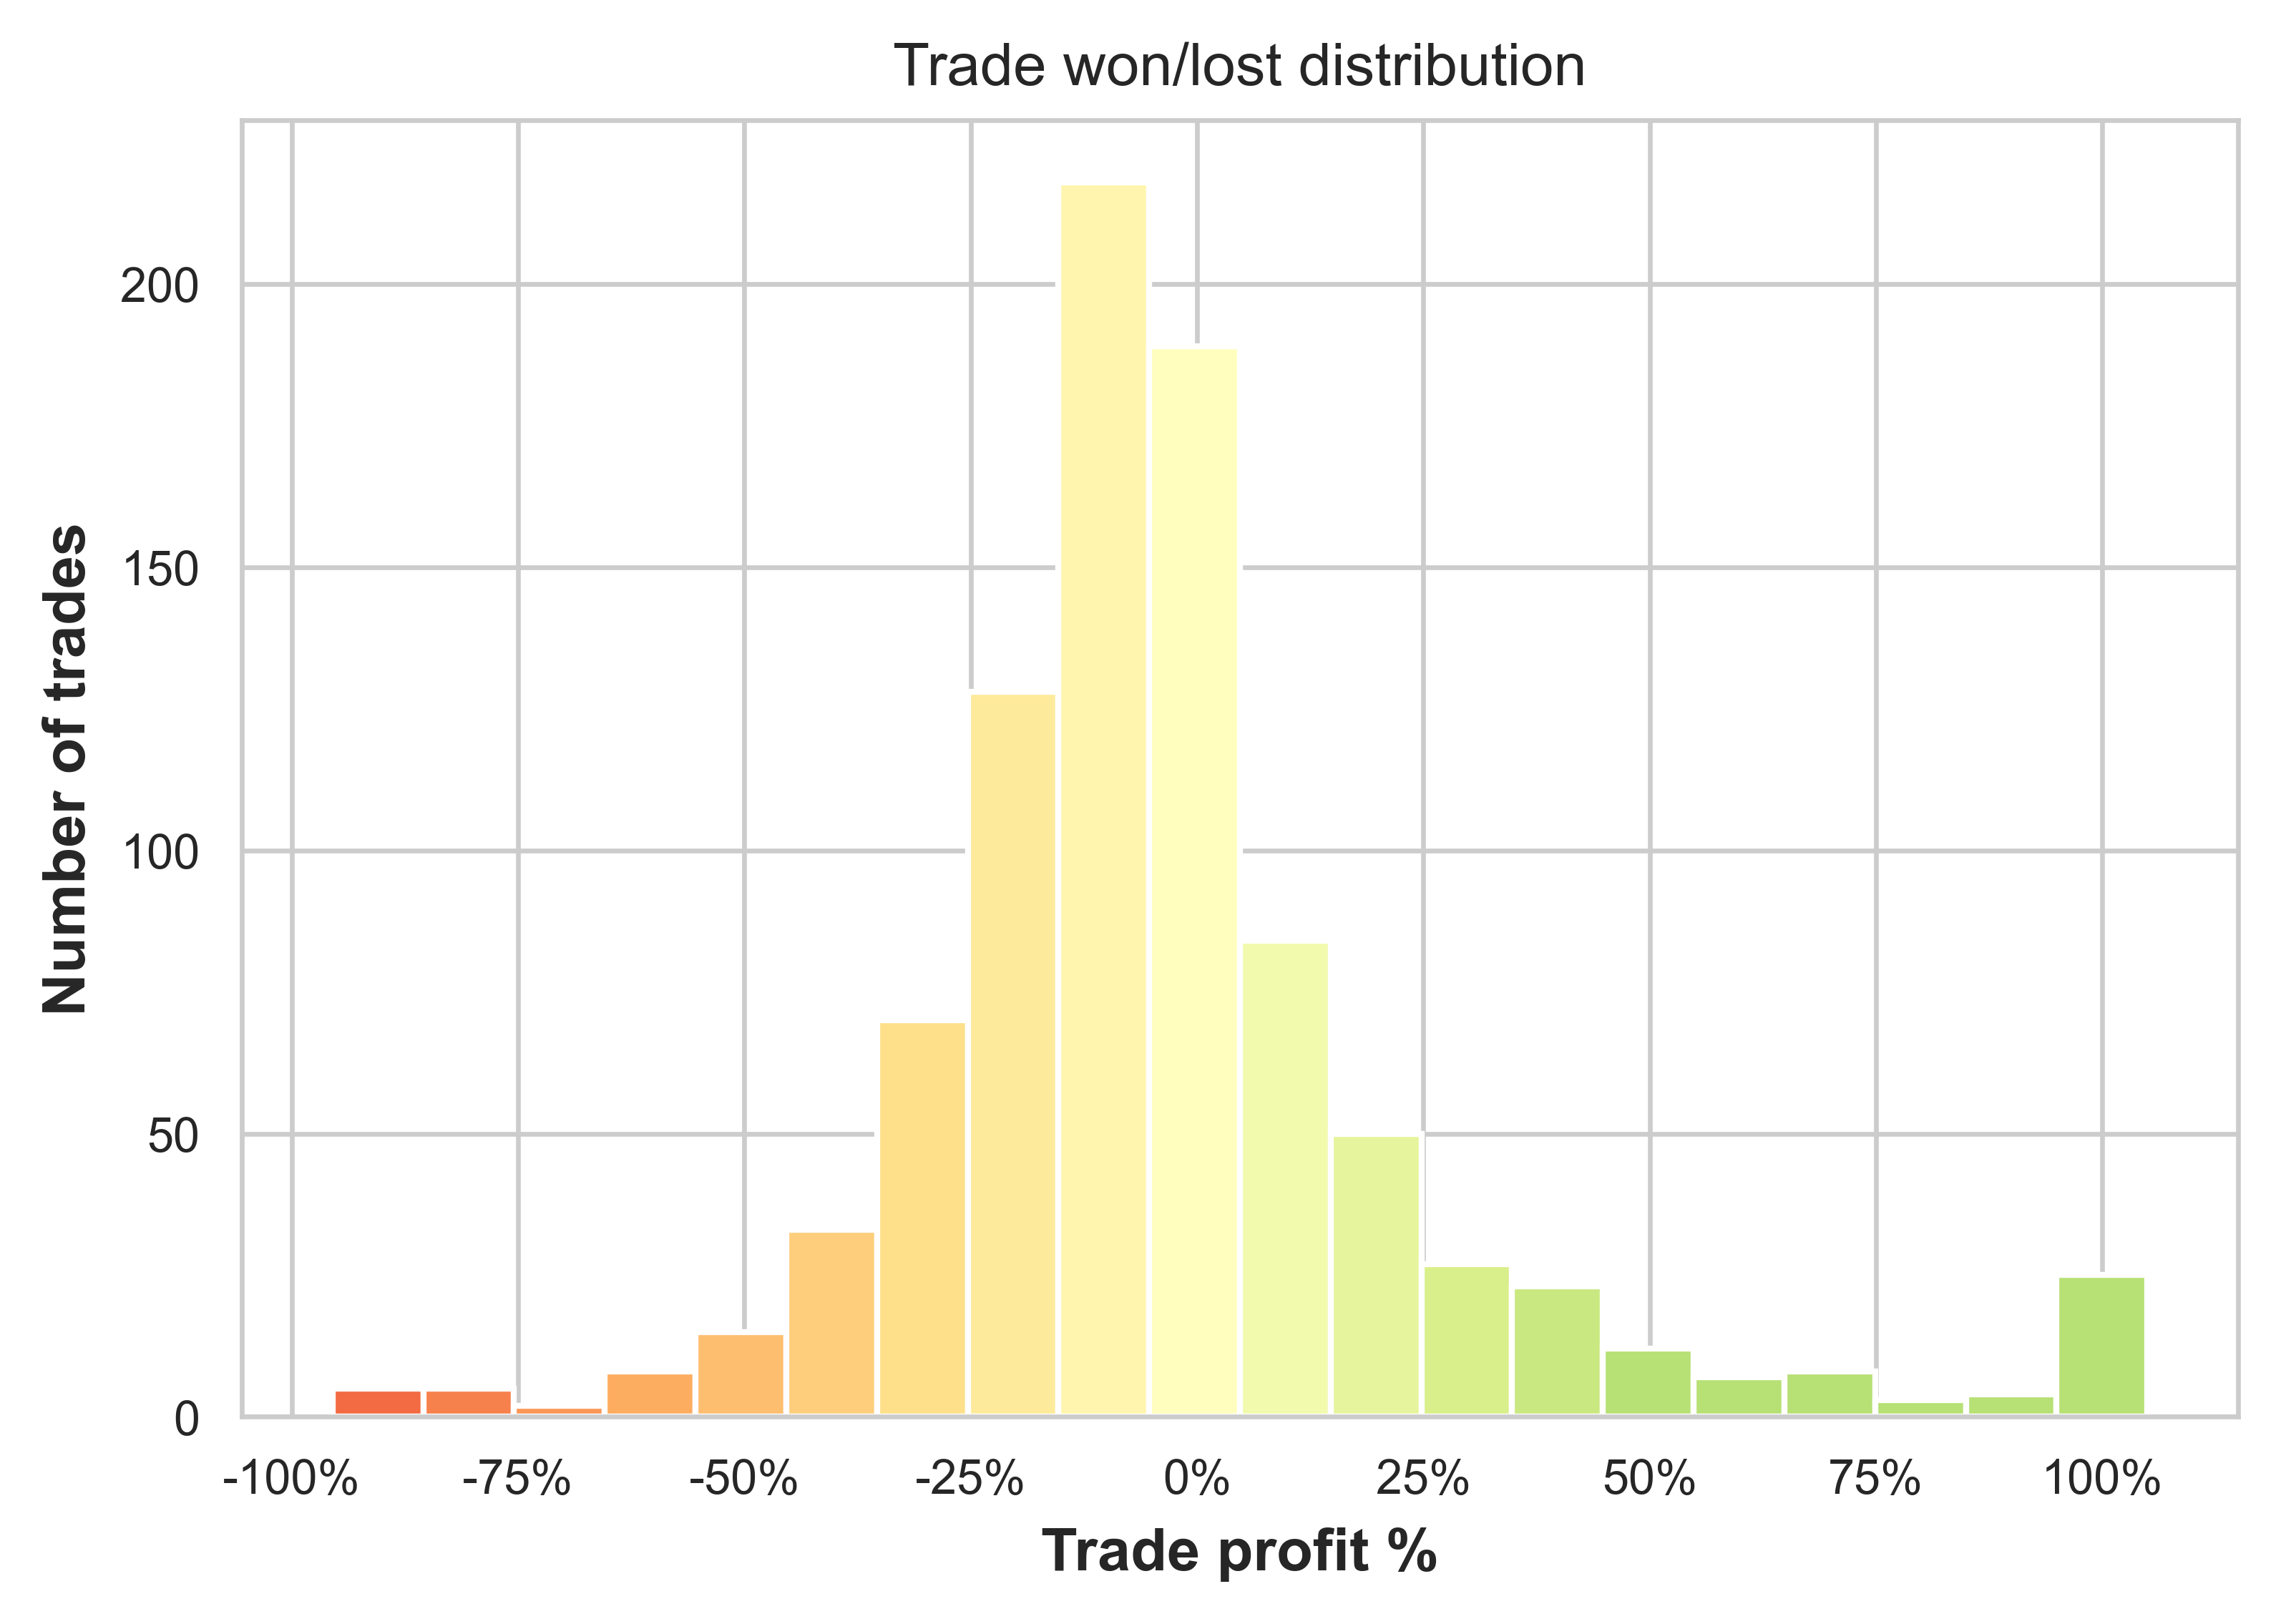

In [82]:
from matplotlib.figure import Figure
from tradingstrategy.analysis.tradeanalyzer import expand_timeline
from tradingstrategy.analysis.profitdistribution import plot_trade_profit_distribution

timeline = trade_analysis.create_timeline()
expanded_timeline, _ = expand_timeline(exchange_universe, pair_universe, timeline)

fig: Figure = plot_trade_profit_distribution(expanded_timeline, bins=20)

### Trading timeline

The timeline displays individual trades the strategy made.
- This is good for figuring out if the algorithm is doing bad trades and how those bad trades look like

In [83]:
from tradingstrategy.analysis.tradeanalyzer import expand_timeline

# Generate raw timeline of position open and close events
timeline = trade_analysis.create_timeline()

# Expand timeline with human-readable exchange and pair symbols
expanded_timeline, apply_styles = expand_timeline(
    exchange_universe,
    pair_universe,
    timeline,
    timestamp_format="%Y-%m-%d",
    hidden_columns=[])

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))

### Portfolio timeline

The evolution of portfolio over the time

* This table describes portfolio construction over different time periods and how the portfolio value evolves

* We output the assets held at the start of the each trading day

* Asset share (weight) may increase or decrease for each day

* Assets are ordered from left to right by their weight

* If asset is not held more than 1 day then it won't appear on the following row and you cannot see the incurring profit/loss - for this use the trading timeline

* If assets are held more than 1 day then the assets are colored based on if they are on profit/loss

In [84]:
from tradingstrategy.analysis.portfolioanalyzer import expand_timeline

# Expand timeline with human-readable exchange and pair symbols
expanded_timeline, apply_styles = expand_timeline(
    exchange_universe,
    pair_universe,
    portfolio_analysis,
    timestamp_format="%Y-%m-%d",
    create_html_styles=True)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Id,Holdings at,NAV USD,Cash USD,#1 asset,#1 value,#1 weight %,#1 PnL,#2 asset,#2 value,#2 weight %,#2 PnL,#3 asset,#3 value,#3 weight %,#3 PnL,#4 asset,#4 value,#4 weight %,#4 PnL
1,2020-11-01,"10,000.00","10,000",,,,,,,,,,,,,,,,
5,2020-11-02,"10,000.00","10,000",,,,,,,,,,,,,,,,
9,2020-11-03,"10,000.00","5,004",UNI,"2,400",48,0.00,ADA,"1,200",24,0.00,BAND,798,16,0.00,ATOM,598,12,0.00
13,2020-11-04,"9,723.80","4,892",BUSD,"2,333",48,0.00,BAKE,"1,167",24,0.00,WBNB,752,16,0.00,DOT,579,12,0.00
17,2020-11-05,"9,615.77","7,498",ADA,"1,154",54,0.00,XRP,577,27,0.00,ETH,387,18,0.00,,,,
21,2020-11-06,"9,662.97","5,132",ETH,"2,021",45,17.07,ADA,"1,160",26,29.79,DOT,771,17,0.00,Cake,580,13,0.00
25,2020-11-07,"9,764.05","6,060",UNI,"2,342",63,0.00,SXP,780,21,0.00,LINK,582,16,0.00,,,,
29,2020-11-08,"10,351.66","6,060",UNI,"2,733",64,390.97,SXP,905,21,124.90,LINK,654,15,71.74,,,,
33,2020-11-09,"10,273.06","6,060",UNI,"2,638",63,295.82,SXP,953,23,172.54,LINK,623,15,40.64,,,,
37,2020-11-10,"10,750.37","6,030",UNI,"2,578",55,730.72,BAND,"1,289",27,0.00,LINK,854,18,92.94,,,,
